In [5]:
import sys
sys.path.insert(0,'../GroundingDINO')
sys.path.insert(0,'../SAM')
import os
import torch
import json
from pytorch3d.io import IO
import numpy as np
from src.utils import normalize_pc,save_colored_pc
from src.render_pc import render_pc
from src.gen_superpoint import gen_superpoint
from groundingdino.util.inference import load_model, load_image, predict, annotate
import cv2
from torchvision.ops import nms
import json
from segment_anything import sam_model_registry, SamPredictor
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import distinctipy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [37]:
def yolobbox2bbox(yolobox):
    x = yolobox[:,0]
    y = yolobox[:,1]
    w = yolobox[:,2]
    h = yolobox[:,3]
    xyxy = np.zeros_like(yolobox)
    xyxy[:,0] = x-w/2
    xyxy[:,1] = y-h/2
    xyxy[:,2] = x+w/2
    xyxy[:,3] = y+h/2
    return xyxy

def toDinoPrompt(metaData,className):
    listOfParts = metaData[className]
    prompt = ""
    partList = {}
    for i,part in enumerate(listOfParts):
        prompt += f"{part} of {className}.".lower()
        partList[f"{part}".lower()] = i
    return prompt,partList

def check_pc_within_bbox(x1, y1, x2, y2, pc):  
    flag = np.logical_and(pc[:, 0] > x1, pc[:, 0] < x2)
    flag = np.logical_and(flag, pc[:, 1] > y1)
    flag = np.logical_and(flag, pc[:, 1] < y2)
    return flag

def InferDINO(INPUT_PATH,category,metaData,modelDINO,predictorSAM,device,BOX_TRESHOLD = 0.2, TEXT_TRESHOLD = 0.3, SCORE_THRESHOLD=0.2,n_neighbors=21,n_pass=3, save_dir="tmp"):
    TEXT_PROMPT,partList = toDinoPrompt(metaData,category)
    io = IO()
    xyz, rgb = normalize_pc(pc_file=INPUT_PATH, save_dir="",io=io, device=device)
    img_list, pc_idx, screen_coords = render_pc(xyz, rgb,save_dir, device, "test")
    preds = []
    preds_dino = []
    for i in range(pc_idx.shape[0]):
        image_source, image = load_image(f"{save_dir}/rendered_img/{i}.png") #load rgb images
        predictorSAM.set_image(image_source)

        boxes, logits, phrases = predict(
                                        model=modelDINO,
                                        image=image,
                                        caption=TEXT_PROMPT,
                                        box_threshold=BOX_TRESHOLD,
                                        text_threshold=TEXT_TRESHOLD
                                    )
        phrases = np.array(phrases) #just to fix indexing

        xyxy = yolobbox2bbox(boxes)*image.shape[-1] #change bbox format to xyxy and scale with image size
        
        nms_mask = []
        for t,bbox in enumerate(xyxy): 
            if check_pc_within_bbox(bbox[0], bbox[1], bbox[2], bbox[3], screen_coords[i]).mean() < 0.95: 
                nms_mask.append(t)
                
        xyxy = xyxy[nms_mask]
        boxes = boxes[nms_mask]
        logits = logits[nms_mask]
        phrases = phrases[nms_mask]
        
        
        
        nms_indexes = nms(torch.tensor(xyxy) , logits, 0.5).numpy() #non maximum supression
        
        xyxy = xyxy[nms_indexes]
        boxes = boxes[nms_indexes]
        logits = logits[nms_indexes]
        phrases = phrases[nms_indexes]
        
        final_indexes = []
        new_phrases = []
        for iindex,part in enumerate(phrases):
            for metaPart in metaData[category]:
                if part.find(metaPart) != -1:
                    final_indexes.append(iindex)
                    new_phrases.append(metaPart)
                    
        
        xyxy = xyxy[final_indexes]
        boxes = boxes[final_indexes]
        logits = logits[final_indexes]
        phrases = np.array(new_phrases)
        preds_dino.append({"image_source":image_source,"xyxy":xyxy[final_indexes],"boxes":boxes[final_indexes],"logits":logits[final_indexes],"phrases":new_phrases})
        
        input_boxes = torch.tensor(xyxy, device=predictorSAM.device)    
        transformed_boxes = predictorSAM.transform.apply_boxes_torch(input_boxes, image_source.shape[:2])
        

        if transformed_boxes.shape[0] > 0:
            masks, _, _ = predictorSAM.predict_torch(
                point_coords=None,
                point_labels=None,
                boxes=transformed_boxes,
                multimask_output=False,
            )    #create segmentation masks with sam

            for index,mask in enumerate(masks):
#                 print(mask[1:].shape)
                preds.append({'image_id': i, 'category_id': phrases[index], 
                              'bbox': boxes[index]*image.shape[-1], 
                              'score': logits[index],
                              'mask':mask[0],
                              'image_source':image_source
                             }
                            )
    pc_aggMask = torch.zeros((xyz.shape[0],len(partList)+1)) #this is a segment agg mask we sum all the scores from our bboxes 
    #into their own respective channel, the last channel is for unsegmented parts
    pc_aggMask[:,-1] = SCORE_THRESHOLD #we can set a confidence threshold by setting the unsegmented score
    for prediction in preds:
        maskedPC_idx = pc_idx[prediction["image_id"],prediction["mask"].cpu().numpy()] #this gives you the pc idx of the points that are inside the mask
        index_pcMasked = np.unique(maskedPC_idx)[1:] # we only need the unique idx and the first id is always -1 meaning not found
        pc_aggMask[index_pcMasked,partList[prediction["category_id"]]] += prediction["score"] #add up all the scores for each part
    pc_seg_classes = torch.argmax(pc_aggMask,dim=-1) #select the highest score as our segmentation class
    #if non of the part scores are over the SCORE_THRESHOLD it will be left unsegmented
    partColors = np.array(distinctipy.get_colors(len(partList)))
    accumulator = np.zeros((xyz.shape[0], len(partList)+1))
    accumulator[:,-1] = 1
    # since projections are not exact meaning not every PC point is rendered into our image our backprojections are not dense
    # use KNN to smooth these backprojections 
    nn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree').fit(xyz) #create a knn
    
    ############# I only added this dict below
    a = {}
    for colorId,part in enumerate(partList):
        pc_part_idx = np.zeros((xyz.shape[0]),dtype=int)
        rgb_sem = np.zeros((xyz.shape[0],3))
        pc_part_idx[torch.where(pc_seg_classes==partList[part])] = 1
        
        for pass_ in range(n_pass):
            notColoredIndexes = torch.where(pc_seg_classes!=partList[part]) #find non segmented parts for smoothing

            n_indexes = nn.kneighbors(xyz[notColoredIndexes],n_neighbors+1,return_distance=False)
            n_indexes = n_indexes[:,1:] #get n_neighbors for the points, the first index is always the point itself so delete that
            #we have dense point clouds so distance based measures are not necessary and sometimes give worst results
            flag = pc_part_idx[n_indexes].mean(axis=1) 
            
            flag[np.where(flag>=0.4)] = 1 #and segmnent the points where the mean of neighbours are colored %40 or over
            flag[np.where(flag<0.4)] = 0
            pc_part_idx[notColoredIndexes] = flag
           
        rgb_sem[pc_part_idx.astype(bool)] = partColors[colorId]
        accumulator[pc_part_idx.astype(bool),colorId] += 1
        save_colored_pc(f"{save_dir}/semantic_segDino_KNN/{part}.ply", xyz, rgb_sem)
        a[part] = rgb_sem
        
    pc_partIDX = np.argmax(accumulator,axis=-1)
    partColors_extended = np.append(partColors,[[0,0,0]],axis=0)
    save_colored_pc(f"{save_dir}/semantic_segDino_KNN/{category}.ply", xyz, partColors_extended[pc_partIDX.astype(int)]) 
    return xyz, rgb_sem,  pc_partIDX,   partColors_extended, a, preds, preds_dino

In [9]:
metaData = json.load(open("./PartNetE_meta.json")) 
device = "cpu"
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
modelDINO = load_model("../GroundingDINO/groundingdino/config/GroundingDINO_SwinB_cfg.py",
                    "../GroundingDINO/weights/groundingdino_swinb_cogcoor.pth",
                    device=device
                    )
sam_checkpoint = "../SAM/weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"


sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device="cuda")

predictorSAM = SamPredictor(sam)

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
category="Chair"
# for category in ["Chair", "Suitcase", "Refrigerator", "Lamp", "Kettle"]: 
input_pc_file = f"data/{category}/2471/pc.ply"
xyz, rgb_sem,  pc_partIDX,   partColors_extended, a, preds, preds_dino = InferDINO(input_pc_file, category, metaData,modelDINO,predictorSAM, device, BOX_TRESHOLD = 0.2,
TEXT_TRESHOLD = 0.3, save_dir=f'examples/zeroshot_{category}')

An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/rhome/kamburoglu/miniconda3/envs/partslip/lib/python3.9/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/rhome/kamburoglu/miniconda3/envs/partslip/lib/python3.9/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt


In [66]:
xyz.shape

(319977, 3)

In [64]:
rgb_sem.shape

(319977, 3)

In [54]:
set(preds)

{0, 1, 2, 3, 4, 5}

In [55]:
label = np.load("data/Chair/2471/label.npy", allow_pickle=True)

In [56]:
label

array({'semantic_seg': array([1, 1, 1, ..., 1, 1, 1], dtype=int32), 'instance_seg': array([2, 2, 2, ..., 2, 2, 2], dtype=int32)},
      dtype=object)

In [57]:
from collections import Counter
Counter(label.item()['semantic_seg'])

Counter({1: 150091, 3: 66169, 0: 57471, 2: 28716, -1: 9084, 4: 8446})

In [86]:
Counter(pc_partIDX)

Counter({1: 140491, 3: 94433, 5: 42912, 2: 27225, 0: 11010, 4: 3906})

In [100]:
print(len(np.where(~np.all(a["arm"] == [0., 0., 0.], axis=1))[0]))
print(len(np.where(~np.all(a["back"] == [0., 0., 0.], axis=1))[0]))
print(len(np.where(~np.all(a["leg"] == [0., 0., 0.], axis=1))[0]))

11010
143070
27240


### segmentation is correct but pc_partIDX does not have the same count

In [15]:
imgResults = []
for prediction in preds:
    annotated_frame = annotate(image_source=prediction["image_source"], boxes=prediction["boxes"], 
                               logits=prediction["logits"], phrases=prediction["phrases"])
    imgResults.append(annotated_frame)

KeyError: 'boxes'

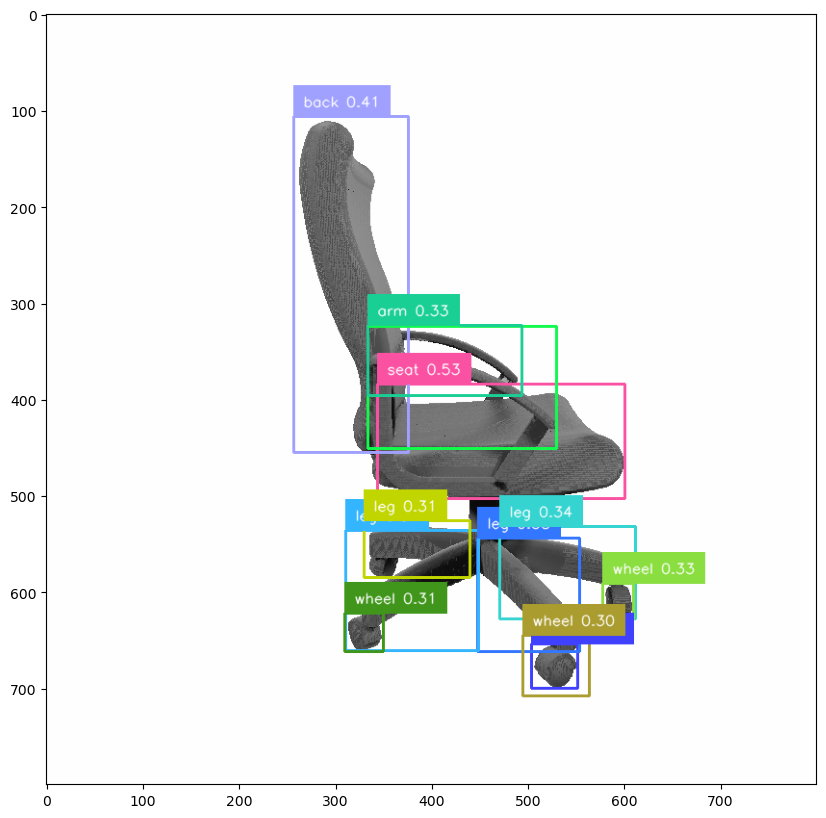

In [76]:
plt.figure(figsize=(10,10))
plt.imshow(imgResults[3])

In [111]:
np.append(np.array(distinctipy.get_colors(10)),[0,0,0])

array([0.        , 1.        , 0.        , 1.        , 0.        ,
       1.        , 0.        , 0.5       , 1.        , 1.        ,
       0.5       , 0.        , 0.5       , 0.75      , 0.5       ,
       0.19644148, 0.02020498, 0.65820572, 0.67849138, 0.03154276,
       0.13699188, 0.8091113 , 0.47183508, 0.93624674, 0.        ,
       1.        , 1.        , 0.19630511, 0.4831913 , 0.04325851,
       0.        , 0.        , 0.        ])

In [119]:
np.append(np.array(distinctipy.get_colors(10)),[[0,0,0]],axis=0)

array([[0.        , 1.        , 0.        ],
       [1.        , 0.        , 1.        ],
       [0.        , 0.5       , 1.        ],
       [1.        , 0.5       , 0.        ],
       [0.5       , 0.75      , 0.5       ],
       [0.57836413, 0.17252648, 0.43206036],
       [0.22293393, 0.01110094, 0.99531654],
       [0.70523271, 0.43708235, 0.96861137],
       [0.00488932, 0.98738614, 0.82831791],
       [0.02163974, 0.50069721, 0.12442037],
       [0.        , 0.        , 0.        ]])

In [114]:
np.array(distinctipy.get_colors(10))

array([[0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 5.00000000e-01, 1.00000000e+00],
       [1.00000000e+00, 5.00000000e-01, 0.00000000e+00],
       [5.00000000e-01, 7.50000000e-01, 5.00000000e-01],
       [3.97058878e-01, 6.04222043e-02, 5.91515890e-01],
       [3.91059031e-01, 4.38415563e-01, 2.55039050e-04],
       [9.95765626e-01, 3.04632604e-02, 2.84273326e-01],
       [0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [9.89732212e-01, 9.84468840e-01, 2.62371739e-01]])